<img src="logos/1773_H_Rocket Buds_RK_01_small.jpg" width=200 align=center />

In [2]:
# Load required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import math
import os
import scipy.integrate

In [5]:
# Folder containing measurement files

folder = "/SSD_Data/Rocketry/Measurements/20210919"

file_list = os.listdir(folder)
file_list.sort()
for file in file_list: print(file)

2021-09-19_17-10-47.txt
2021-09-19_17-12-27.txt
2021-09-19_17-15-54.txt
2021-09-19_17-18-27.txt
2021-09-19_17-20-16.txt
2021-09-19_17-21-26.txt
2021-09-19_17-24-33.txt
2021-09-19_17-26-11.txt


550


<Figure size 1152x648 with 0 Axes>

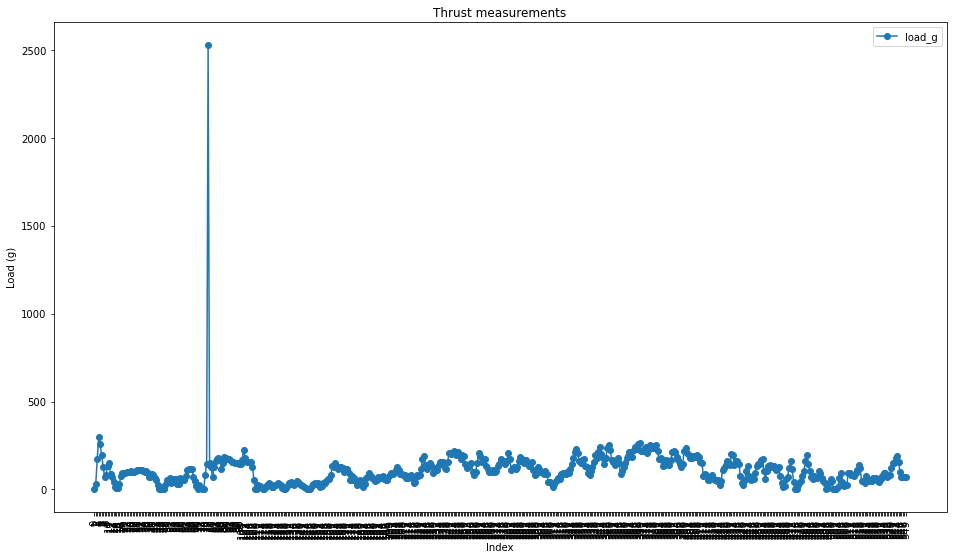

FileNotFoundError: [Errno 2] No such file or directory: '/SSD_Data/Rocketry/Measurements/20210919/RAWCleaned/2021-09-19_17-26-11.txt_clean.txt'

In [8]:
# Module for cleaning up measurement files, one by one

file = '2021-09-19_17-26-11.txt'

fig = plt.figure(figsize=(16, 9)) # Prepare plot for populating
df = pd.read_csv(folder + "/" + file, sep=r';', engine='python', header=None, names=['time_s','load_g']) # Open each file as timeseries dataframe
df.loc[df.load_g < 0, 'load_g'] = 0 # Replace negative values with zero
print(len(df)) # check number of measurement points

START = 0
END = len(df)

#replace outlier in specific point with average of before and after
#point = 77
#df.at[point, 'load_g'] = (df[['load_g']].iloc[point-1] + df[['load_g']].iloc[point+1])/2

df = df.iloc[np.r_[START:END]]
axs = df.reset_index().plot.line(x='index', y="load_g", figsize=(16, 9), title=file, style='o-') # plot measurement points

plt.xticks(range(START,END), rotation=90)
plt.title("Thrust measurements")
plt.xlabel("Index")
plt.ylabel("Load (g)")
plt.show()

df.to_csv(folder + "Cleaned/" + file + "_clean.txt", sep=r';', index=False, header=False)

In [61]:
# Classify engine based on impulse

def engine_designation(imp_ns, thr_n):
    if imp_ns <= 2.5:
        impulse = "A"
    elif  imp_ns <= 5.0:
        impulse = "B"
    elif  imp_ns <= 10.0:
        impulse = "C"
    elif  imp_ns <= 20.0:
        impulse = "D"
    elif  imp_ns <= 40.0:
        impulse = "E"
    elif  imp_ns <= 80.0:
        impulse = "F"
    elif  imp_ns <= 160.0:
        impulse = "G"
    elif  imp_ns <= 320.0:
        impulse = "H"
    elif  imp_ns <= 640.0:
        impulse = "I"
    elif  imp_ns <= 1280.0:
        impulse = "J"
    elif  imp_ns <= 2560.0:
        impulse = "K"
    elif  imp_ns <= 5120.0:
        impulse = "L"
    elif  imp_ns <= 10240.0:
        impulse = "M"
    elif  imp_ns <= 20480.0:
        impulse = "N"
    elif  imp_ns <= 40960.0:
        impulse = "O"
    elif  imp_ns <= 81920.0:
        impulse = "P"
    elif  imp_ns <= 163840.0:
        impulse = "Q"
    elif  imp_ns <= 327680.0:
        impulse = "R"
    elif  imp_ns <= 655360.0:
        impulse = "S"
    else:
        impulse = "OoB"
    return impulse + str(math.floor(thr_n))

In [120]:
#https://medium.com/@krzysztofdrelczuk/time-series-anomaly-detection-with-python-example-a92ef262f09a
    
summary_df = pd.DataFrame(columns = ["filename","Thrust_max_N","Thrust_mean_N","Impulse_Ns","Class"]) # Initialize dataframe
df_lst = []

for filename in sorted(glob.glob(folder + "Cleaned/" + '*_clean.txt')):
    df = pd.read_csv(filename, sep=r';', engine='python', header=None, names=['time_s','load_g']) # Open each file as timeseries dataframe
    
    # Data processing
    df['file'] = filename[-29:-4]
    df['thrust_N'] = df['load_g'] / 1000 * 10 # Convert mass grams to kg to N
    df['time_s'] = df['time_s'] - df['time_s'].iloc[0] # Convert all timestamps to relative to recording start
    df.loc[df.thrust_N < 0, 'thrust_N'] = 0 # Replace negative values with zero
    df_lst.append(df)

    summary_df = summary_df.append({
        "filename": filename[-29:-4], 
        "Thrust_max_N": df.describe()['load_g']['max'], 
        "Thrust_mean_N": df.describe()['load_g']['mean'], 
        "Impulse_Ns": np.trapz(y=df['load_g'], x=df['time_s'])
    }, ignore_index=True)
    summary_df["Class"] = summary_df.apply(lambda x: engine_designation(x.Impulse_Ns, x.Thrust_mean_N), axis=1)

print(summary_df)
summary_df.to_csv(folder + 'thrust_measurement_table.csv', index=False)

                    filename  Thrust_max_N  Thrust_mean_N   Impulse_Ns Class
0  -09-19_17-10-47.txt_clean    149.081301      51.377451   164.743719   H51
1  -09-19_17-12-27.txt_clean    677.109079     265.957734   977.218317  J265
2  -09-19_17-15-54.txt_clean    456.342141     398.188366  4726.054495  L398
3  -09-19_17-18-27.txt_clean    208.978997      67.261111   631.407497   I67
4  -09-19_17-20-16.txt_clean   1188.038957     558.367116  2309.203294  K558
5  -09-19_17-21-26.txt_clean   1218.708672     579.852314  1696.539193  K579


In [121]:
import pickle

with open('df_lst.pkl_20210919', 'wb') as f:
    pickle.dump(df_lst, f)

In [122]:
# Plot visualization with Bokeh

from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show
output_notebook()

def color_gen():
    return (round(np.random.random()*250), round(np.random.random()*250), round(np.random.random()*250))

TOOLS = "pan, wheel_zoom, box_zoom, reset, save, box_select"
p = figure(x_axis_type="auto", tools=TOOLS, width=1280, height=720, 
           title="Thrust (N) vs Time (sec) Plot", x_axis_label='Time (sec)', y_axis_label='Thrust (N)')

for df in df_lst:
    x = df['time_s']
    y = df['thrust_N']
    source = ColumnDataSource(df)
    p.line('time_s', 'thrust_N', source=source, legend_label=df['file'][0], line_width=3, color=color_gen())
    tooltips=[("file", "@file"), ("time_s", "@time_s"), ("thrust_N", "@thrust_N")]
    p.add_tools(HoverTool(tooltips=tooltips))

output_file(folder + 'thrust_graph.html')
show(p)

Loading BokehJS ...